# option implied VaR and CVaR


## VaR
**1. 风险价值 (Value at Risk, VaR)**

- **概念：** VaR 是指在**正常市场条件**下，给定一定的**置信水平**（Confidence Level）和一定的**持有期**（Time Horizon），一项投资或一个投资组合预期可能发生的最大损失值。
- **通俗解释：** 假设你管理一个投资组合，你想知道在接下来的1天内，有95%的可能性，你的最大损失不会超过多少钱。这个“多少钱”就是置信水平为95%、持有期为1天的VaR。
  - 换句话说，VaR 回答的是：“在给定的概率下，我的损失不会超过多少？” 或者 “我有 X% 的把握，在未来 N 天内，我的损失不会超过 V 元。”
- **计算公式**：
  $$ \mathrm{VaR}_{t,T}^{\alpha} = S_t - K^{\alpha} $$

- **通过看跌期权反解置信水平：**
  $$p_t = e^{-r_{t,T} \cdot T} \int_0^K (K - S_t) f(S_{t,T}) \mathrm{d}S_{t,T}$$
  对K求导可得：
  $$\begin{align*}
  \frac{dp_t}{dK} &= e^{-r_{t,T} \cdot T} \int_0^K f(S_{t,T}) dS_{t,T} \\
  &= e^{-r_{t,T} \cdot T} F(K) \\
  &= e^{-r_{t,T} \cdot T} \alpha.
  \end{align*}
  $$
  使用离散化求数值解：
  $$ \begin{align*}\alpha &= \frac{1}{2} \left[ \frac{dp^{\text{UP}}}{dK^{\text{UP}}} + \frac{dp^{\text{DOWN}}}{dK^{\text{DOWN}}} \right] \\&= \frac{1}{2} \left[ \frac{p_3 - p_2}{K_3 - K_2} + \frac{p_2 - p_1}{K_2 - K_1} \right]\end{align*}$$

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pandas as pd
from pandas.tseries.offsets import WeekOfMonth
import matplotlib.pyplot as plt

ts.set_token(os.getenv("TS_TOKEN"))  # 设置token
pro = ts.pro_api()

In [2]:
# 设置绘图格式
plt.rcParams._N = 1  # 高宽乘数
plt.rcParams._fig_hight = 8  # 画布高
plt.rcParams._fig_weight = 8 * 1.618  # 画布宽
plt.rcParams.update(
    {
        "figure.figsize": tuple(
            i * plt.rcParams._N
            for i in (plt.rcParams._fig_weight, plt.rcParams._fig_hight)
        ),
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "lines.linewidth": 1.5,
        "lines.markersize": 8,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "font.family": "SimSun",
        "font.serif": "Times New Roman",
        "axes.facecolor": "#f7f7f7",
        "figure.facecolor": "#ffffff",
        "axes.edgecolor": "gray",
        "axes.linewidth": 1.2,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "axes.unicode_minus": False,
    }
)

In [3]:
def get_date(year, month, week=4, weekday=3):
    # 使用 WeekOfMonth 计算第四个星期三
    forth_thursday = pd.Timestamp(
        year=year, month=month, day=1
    ) + WeekOfMonth(  # 该月第一天
        week=week - 1, weekday=weekday - 1
    )  # week=3 表示第四个（0-based），weekday=2 是星期三
    return forth_thursday


def get_option(
    ts_pro,
    exchange="SSE",
    fields="ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg",
    option="上证50",
    S0Code="510050.SH",
    date="20250424",
):
    tempDate = pd.to_datetime(date)
    # 获取期权合约信息
    optDf = ts_pro.opt_basic(
        exchange=exchange,
        fields=fields,
    )
    # 筛选出目标期权
    optDf = optDf.loc[optDf.name.apply(lambda x: option in x)]
    # 转换时间戳数据类型
    optDf.loc[:, ["list_date", "delist_date"]] = optDf.loc[
        :, ["list_date", "delist_date"]
    ].apply(lambda x: pd.to_datetime(x))
    optDf = optDf.convert_dtypes()
    # 计算剩余到期月份，获得目标期权合约
    optDf.loc[:, "remain"] = (optDf["delist_date"] - tempDate).apply(lambda x: x.days)

    # 最近一个到期月期权剩余天数
    latest_remain_days = (
        get_date(tempDate.year, tempDate.month + 1)
        - get_date(tempDate.year, tempDate.month)
    ).days - 1

    optDf = optDf.loc[optDf.loc[:, "remain"] == latest_remain_days]
    optDf = optDf.sort_values(["call_put", "exercise_price"])

    # 获取行情数据
    optDfDailyAll = pro.opt_daily(trade_date=date, exchange=exchange)
    # 筛选期权
    optDfDailyAll = optDfDailyAll[optDfDailyAll.ts_code.isin(optDf.ts_code)]
    optDf = optDf.merge(optDfDailyAll, on="ts_code")

    # 获取标的资产的价格
    optDf["s0"] = pro.fund_daily(ts_code=S0Code, start_date=date, end_date=date).close[
        0
    ]
    optDf["shibor_1m"] = (
        pro.shibor(start_date="20250424", end_date="20250424")["1m"][0] / 100
    )

    optDf["trade_date"] = pd.to_datetime(optDf["trade_date"])
    optDf["ttm"] = (optDf.delist_date - optDf.trade_date).apply(lambda x: x.days) / 365
    return optDf


def option_clean(
    optDf,
    required_cols=[
        "call_put",
        "exercise_price",
        "delist_date",
        "trade_date",
        "close",
        "vol",
        "s0",
        "shibor_1m",
        "ttm",
    ],
):
    # 数据预处理
    print(f"开始筛选数据，初始条数: {len(optDf)}")
    data_filtered = optDf.copy()

    # 确保必要列存在
    missing_cols = [col for col in required_cols if col not in data_filtered.columns]
    if missing_cols:
        raise ValueError(f"输入DataFrame缺少必要列: {missing_cols}")

    # 删除必要列中的缺失值 (NaN)
    original_count = len(data_filtered)
    data_filtered.dropna(subset=required_cols, inplace=True)
    print(
        f"删除缺失值后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
    )

    # 确保数值类型正确，错误的值转为NaN再删除
    numeric_cols = ["exercise_price", "close", "vol", "s0", "shibor_1m", "ttm"]
    for col in numeric_cols:
        data_filtered[col] = pd.to_numeric(data_filtered[col], errors="coerce")
    original_count = len(data_filtered)
    data_filtered.dropna(subset=numeric_cols, inplace=True)  # 删除因类型转换产生的NaN
    if original_count > len(data_filtered):
        print(
            f"删除无效数值后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # 筛选看涨 ('C') 和看跌 ('P') 期权，假设这是你的数据约定
    # 如果你的 'call_put' 列使用其他标识 (如 1/0)，请相应修改
    valid_option_types = ["C", "P"]  # 或者 [1, 0] 等
    original_count = len(data_filtered)
    data_filtered = data_filtered[data_filtered["call_put"].isin(valid_option_types)]
    if original_count > len(data_filtered):
        print(
            f"筛选期权类型 ('C'/'P') 后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 1. 基于流动性和价格的简单过滤 ---
    min_volume = 100  # 最小成交量 (论文中可能使用更高阈值，如10，根据实际情况调整)
    min_price = 0.0001  # 最小期权价格 (例如，避免价格过低带来的噪音，单位与'close'一致)

    original_count = len(data_filtered)
    # 筛选成交量
    data_filtered = data_filtered[data_filtered["vol"] >= min_volume]
    # 筛选价格
    data_filtered = data_filtered[data_filtered["close"] >= min_price]
    if original_count > len(data_filtered):
        print(
            f"基于最小成交量(>={min_volume})和最小价格(>={min_price})筛选后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 2. 基于到期时间的过滤 ---
    # 论文通常会排除临近到期和远期合约
    min_ttm_days = 7  # 最小剩余天数 (例如，排除最后一周，避免gamma风险和展期效应)
    max_ttm_days = 365  # 最大剩余天数 (例如，排除超过一年的，流动性可能较差)

    # 假设 ttm 列的单位是年，转换为天数进行比较
    data_filtered["ttm_days"] = data_filtered["ttm"] * 365
    original_count = len(data_filtered)
    data_filtered = data_filtered[
        (data_filtered["ttm_days"] >= min_ttm_days)
        & (data_filtered["ttm_days"] <= max_ttm_days)
    ]
    if original_count > len(data_filtered):
        print(
            f"基于到期时间 ({min_ttm_days}-{max_ttm_days} 天) 筛选后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 3. 基于无套利条件的过滤 ---
    # 这一步对于保证后续计算的稳定性至关重要

    # 3.1 检查内在价值下限 (期权价格不能低于其内在价值)
    # C >= max(0, S0 - K * exp(-r*T))
    # P >= max(0, K * exp(-r*T) - S0)

    discount_factor = np.exp(-data_filtered["shibor_1m"] * data_filtered["ttm"])
    call_violation = (data_filtered.call_put == "C") & (
        data_filtered.close
        > np.maximum(
            data_filtered["s0"] - data_filtered["exercise_price"] * discount_factor, 0
        )
    )
    put_violation = (data_filtered.call_put == "P") & (
        data_filtered.close
        > np.maximum(
            0, data_filtered["exercise_price"] * discount_factor - data_filtered["s0"]
        )
    )

    original_count = len(data_filtered)
    data_filtered = data_filtered[(call_violation | put_violation)]
    removed_count = original_count - len(data_filtered)
    if removed_count > 0:
        print(
            f"移除违反内在价值下限的期权后剩余条数: {len(data_filtered)} (移除了 {removed_count} 条)"
        )
    return data_filtered

In [4]:
optDf = get_option(
    pro,
    # exchange="SSE",
    # fields="ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg",
    # option="沪深300",
    # S0Code="510300.SH",
    # date="20250424",
)


optDf

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain,...,high,low,close,settle,vol,amount,oi,s0,shibor_1m,ttm
0,10009155.SH,OP510050.SH,华夏上证50ETF期权2505认购2.35,10000,C,2.35,2025-04-08,2025-05-28,0.0001,34,...,0.3753,0.3580,0.3674,0.3650,68.0,25.0892,486.0,2.715,0.01747,0.093151
1,10009156.SH,OP510050.SH,华夏上证50ETF期权2505认购2.40,10000,C,2.4,2025-04-08,2025-05-28,0.0001,34,...,0.3240,0.3080,0.3150,0.3150,78.0,24.8581,273.0,2.715,0.01747,0.093151
2,10009157.SH,OP510050.SH,华夏上证50ETF期权2505认购2.45,10000,C,2.45,2025-04-08,2025-05-28,0.0001,34,...,0.2750,0.2600,0.2648,0.2650,59.0,15.7726,559.0,2.715,0.01747,0.093151
3,10009147.SH,OP510050.SH,华夏上证50ETF期权2505认购2.50,10000,C,2.5,2025-04-02,2025-05-28,0.0001,34,...,0.2283,0.2110,0.2170,0.2170,941.0,205.7281,4874.0,2.715,0.01747,0.093151
4,10009051.SH,OP510050.SH,华夏上证50ETF期权2505认购2.55,10000,C,2.55,2025-03-27,2025-05-28,0.0001,34,...,0.1807,0.1631,0.1689,0.1689,2687.0,463.9787,5685.0,2.715,0.01747,0.093151
5,10009052.SH,OP510050.SH,华夏上证50ETF期权2505认购2.60,10000,C,2.6,2025-03-27,2025-05-28,0.0001,34,...,0.1349,0.1186,0.1247,0.1247,9135.0,1162.1232,9354.0,2.715,0.01747,0.093151
6,10009053.SH,OP510050.SH,华夏上证50ETF期权2505认购2.65,10000,C,2.65,2025-03-27,2025-05-28,0.0001,34,...,0.0931,0.0776,0.0845,0.0845,31924.0,2755.1042,23530.0,2.715,0.01747,0.093151
7,10009054.SH,OP510050.SH,华夏上证50ETF期权2505认购2.70,10000,C,2.7,2025-03-27,2025-05-28,0.0001,34,...,0.0583,0.0474,0.0520,0.0520,80732.0,4282.4317,56662.0,2.715,0.01747,0.093151
8,10009055.SH,OP510050.SH,华夏上证50ETF期权2505认购2.75,10000,C,2.75,2025-03-27,2025-05-28,0.0001,34,...,0.0325,0.0260,0.0284,0.0284,70221.0,2065.6026,59920.0,2.715,0.01747,0.093151
9,10009056.SH,OP510050.SH,华夏上证50ETF期权2505认购2.80,10000,C,2.8,2025-03-27,2025-05-28,0.0001,34,...,0.0168,0.0134,0.0147,0.0147,38588.0,589.0473,45779.0,2.715,0.01747,0.093151


In [5]:
data_filtered = option_clean(optDf)
data_filtered

开始筛选数据，初始条数: 26
删除缺失值后剩余条数: 26 (移除了 0 条)
基于最小成交量(>=100)和最小价格(>=0.0001)筛选后剩余条数: 23 (移除了 3 条)
移除违反内在价值下限的期权后剩余条数: 21 (移除了 2 条)


,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain,...,low,close,settle,vol,amount,oi,s0,shibor_1m,ttm,ttm_days
5,10009052.SH,OP510050.SH,华夏上证50ETF期权2505认购2.60,10000,C,2.6,2025-03-27,2025-05-28,0.0001,34,...,0.1186,0.1247,0.1247,9135.0,1162.1232,9354.0,2.715,0.01747,0.093151,34.0
6,10009053.SH,OP510050.SH,华夏上证50ETF期权2505认购2.65,10000,C,2.65,2025-03-27,2025-05-28,0.0001,34,...,0.0776,0.0845,0.0845,31924.0,2755.1042,23530.0,2.715,0.01747,0.093151,34.0
7,10009054.SH,OP510050.SH,华夏上证50ETF期权2505认购2.70,10000,C,2.7,2025-03-27,2025-05-28,0.0001,34,...,0.0474,0.0520,0.0520,80732.0,4282.4317,56662.0,2.715,0.01747,0.093151,34.0
8,10009055.SH,OP510050.SH,华夏上证50ETF期权2505认购2.75,10000,C,2.75,2025-03-27,2025-05-28,0.0001,34,...,0.0260,0.0284,0.0284,70221.0,2065.6026,59920.0,2.715,0.01747,0.093151,34.0
9,10009056.SH,OP510050.SH,华夏上证50ETF期权2505认购2.80,10000,C,2.8,2025-03-27,2025-05-28,0.0001,34,...,0.0134,0.0147,0.0147,38588.0,589.0473,45779.0,2.715,0.01747,0.093151,34.0
10,10009057.SH,OP510050.SH,华夏上证50ETF期权2505认购2.85,10000,C,2.85,2025-03-27,2025-05-28,0.0001,34,...,0.0076,0.0080,0.0080,14394.0,120.9452,34407.0,2.715,0.01747,0.093151,34.0
11,10009058.SH,OP510050.SH,华夏上证50ETF期权2505认购2.90,10000,C,2.9,2025-03-27,2025-05-28,0.0001,34,...,0.0045,0.0050,0.0050,7260.0,37.5089,23113.0,2.715,0.01747,0.093151,34.0
12,10009059.SH,OP510050.SH,华夏上证50ETF期权2505认购2.95,10000,C,2.95,2025-03-27,2025-05-28,0.0001,34,...,0.0033,0.0033,0.0033,8660.0,31.0571,26866.0,2.715,0.01747,0.093151,34.0
13,10009158.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.35,10000,P,2.35,2025-04-08,2025-05-28,0.0001,34,...,0.0019,0.0024,0.0024,6471.0,14.8169,16286.0,2.715,0.01747,0.093151,34.0
14,10009159.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.40,10000,P,2.4,2025-04-08,2025-05-28,0.0001,34,...,0.0022,0.0027,0.0027,3224.0,8.2894,9061.0,2.715,0.01747,0.093151,34.0


In [6]:
# 计算隐含波动率
def get_implied_VaR(data_filtered, call_put="P"):
    data_filtered = data_filtered[data_filtered.call_put == call_put.upper()][
        ["call_put", "exercise_price", "s0", "close", "shibor_1m", "ttm"]
    ]
    data_filtered["VaR"] = data_filtered.s0 - data_filtered.exercise_price
    data_filtered["p3-p2"] = (data_filtered.close - data_filtered.close.shift(1)).shift(
        -1
    )
    data_filtered["p2-p1"] = data_filtered.close - data_filtered.close.shift(1)
    data_filtered["k3-k2"] = (
        data_filtered.exercise_price - data_filtered.exercise_price.shift(1)
    ).shift(-1)
    data_filtered["k2-k1"] = (
        data_filtered.exercise_price - data_filtered.exercise_price.shift(1)
    )
    data_filtered = data_filtered.dropna()
    data_filtered.loc[:, "alpha"] = (
        np.exp(data_filtered["shibor_1m"] * data_filtered["ttm"])
        * (
            data_filtered["p3-p2"] / data_filtered["k3-k2"]
            + data_filtered["p2-p1"] / data_filtered["k2-k1"]
        )
        / 2
    )
    return data_filtered

In [7]:
downside_risk = get_implied_VaR(data_filtered, call_put="P")

In [8]:
downside_risk

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.011018
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.027044
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.04307
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.069112
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.148241
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.266433
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.423689
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.634031
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.811319
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.899463


## CVaR
**2. 条件风险价值 (Conditional Value at Risk, CVaR)**

- **概念：** CVaR 是指在损失**超过**VaR阈值的条件下，投资或投资组合的预期（平均）损失。
- **通俗解释：** 接着上面的例子，如果95% VaR是100万，意味着有5%的可能性损失会超过100万。CVaR回答的问题是：“如果那5%的不利情况真的发生了，平均来说我的损失会是多少？” 这个平均损失就是CVaR。

In [9]:
downside_risk.loc[:, "CVaR"] = (
    np.exp(downside_risk["shibor_1m"] * downside_risk["ttm"])
    * downside_risk.close
    / downside_risk.alpha
    + downside_risk.VaR
)
downside_risk

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.011018,0.560455
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.027044,0.39463
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.04307,0.340581
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.069112,0.278043
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.148241,0.198108
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.266433,0.149962
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.423689,0.106962
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.634031,0.067528
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.811319,0.041173
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.899463,0.027472


## 通过隐含波动率进行计算

In [10]:
from scipy.optimize import root, fsolve
from numpy import log, exp, sqrt
from scipy import stats
from scipy.optimize import fsolve


class European_option:

    def __init__(self, s0, exercise_price, ttm, shibor_1m, sigma, opt: str):
        self.s0 = s0
        self.exercise_price = exercise_price
        self.ttm = ttm
        self.shibor_1m = shibor_1m
        self.sigma = sigma
        self.opt = opt

    def value(self):
        d1 = (
            log(self.s0 / self.exercise_price)
            + (self.shibor_1m + 0.5 * self.sigma**2) * (self.ttm)
        ) / (self.sigma * sqrt(self.ttm))
        d2 = d1 - self.sigma * sqrt(self.ttm)
        if self.opt.upper() == "C":
            value = self.s0 * stats.norm.cdf(d1) - self.exercise_price * exp(
                -self.shibor_1m * (self.ttm)
            ) * stats.norm.cdf(d2)
        else:
            value = self.exercise_price * exp(
                -self.shibor_1m * (self.ttm)
            ) * stats.norm.cdf(-d2) - self.s0 * stats.norm.cdf(-d1)

        return value

    def imp_vol(self, C0, sigma_est=0.15):
        option = European_option(
            self.s0, self.exercise_price, self.ttm, self.shibor_1m, self.sigma, self.opt
        )

        def difference(sigma):
            option.sigma = sigma
            return option.value() - C0

        iv = fsolve(difference, sigma_est)[0]
        return iv


def calculate_iv(data):
    data.loc[:, "imp_vol"] = ""
    for row, option in data.iterrows():
        ttm = option["ttm"]
        shibor_1m = option["shibor_1m"]
        s0 = option["s0"]
        exercise_price = option["exercise_price"]
        sigma_estt = 0.15
        opt = option["call_put"]

        option_temp = European_option(
            s0, exercise_price, ttm, shibor_1m, sigma_estt, opt
        )

        V0 = option["close"]
        data.loc[row, "imp_vol"] = option_temp.imp_vol(V0)

    return data

In [11]:
downside_risk = calculate_iv(downside_risk)
downside_risk

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR,imp_vol
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.011018,0.560455,0.230215
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.027044,0.39463,0.208879
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.04307,0.340581,0.194039
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.069112,0.278043,0.174962
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.148241,0.198108,0.158788
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.266433,0.149962,0.152507
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.423689,0.106962,0.145651
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.634031,0.067528,0.144709
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.811319,0.041173,0.156381
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.899463,0.027472,0.175087


In [12]:
d2 = (
    np.log(downside_risk.s0 / downside_risk.exercise_price)
    - downside_risk.imp_vol**2 * downside_risk.ttm / 2
) / (downside_risk.imp_vol * np.sqrt(downside_risk.ttm))
downside_risk["alpha_BS"] = 1 - pd.Series(
    map(stats.norm.cdf, d2), index=downside_risk.index
)
downside_risk

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR,imp_vol,alpha_BS
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.011018,0.560455,0.230215,0.042713
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.027044,0.39463,0.208879,0.057152
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.04307,0.340581,0.194039,0.086366
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.069112,0.278043,0.174962,0.125599
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.148241,0.198108,0.158788,0.192470
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.266433,0.149962,0.152507,0.309476
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.423689,0.106962,0.145651,0.459219
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.634031,0.067528,0.144709,0.622518
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.811319,0.041173,0.156381,0.748493
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.899463,0.027472,0.175087,0.825060


Text(0.5, 1.0, '$Model \\ free \\ vs \\ BS (cdf)$')

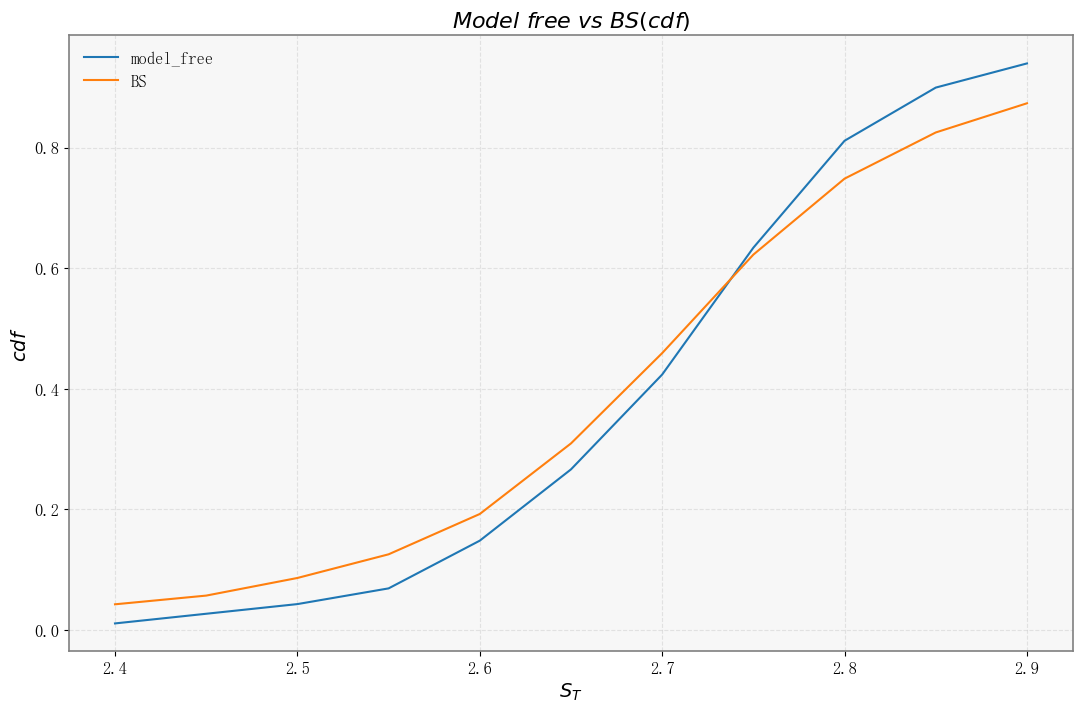

In [13]:
plt.plot(downside_risk.exercise_price, downside_risk.alpha, label="model_free")
plt.plot(downside_risk.exercise_price, downside_risk.alpha_BS, label="BS")
plt.legend()
plt.xlabel("$S_T$")
plt.ylabel("$cdf$")
plt.title("$Model \ free \ vs \ BS (cdf)$")

In [14]:
from scipy.interpolate import CubicSpline

# 拟合CDF的三次样条
cs = CubicSpline(
    downside_risk.exercise_price, downside_risk.alpha, bc_type="natural"
)  # 'natural'边界二阶导为0

# 求导得到PDF
x = np.arange(2.4, 2.91, 0.01)
f = cs.derivative()(x)  # f(downside_risk.exercise_price)是PDF

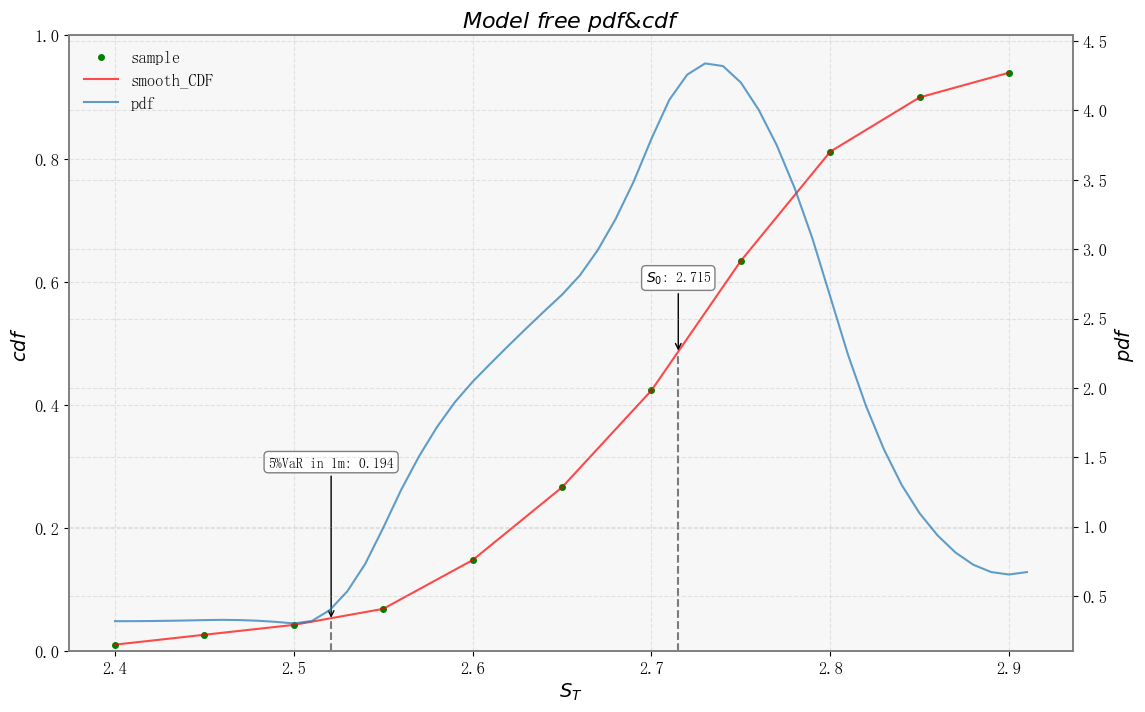

In [15]:
# model free绘图
s0 = downside_risk.s0.iloc[0]
plt.plot(downside_risk.exercise_price, downside_risk.alpha, "g.", label="sample")
plt.plot(
    downside_risk.exercise_price,
    cs(downside_risk.exercise_price),
    label="smooth_CDF",
    alpha=0.7,
    color="r",
)
lines1, labels1 = plt.gca().get_legend_handles_labels()  # ax1的线和标签
plt.ylim(0, 1)

plt.xlabel("$S_T$")
plt.vlines(
    s0,
    0,
    cs(s0),
    "k",
    linestyles="--",
    alpha=0.5,
)
plt.annotate(
    f"$S_0$: {s0:.3f}",  # 标签文本
    xy=(s0, cs(s0)),  # 箭头指向的位置
    xytext=(s0, 0.6),  # 文本位置
    arrowprops=dict(arrowstyle="->", color="black"),  # 箭头样式
    ha="center",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
)
_5VarSt = cs.solve(0.05)[0]
_5Var = s0 - _5VarSt
plt.vlines(
    _5VarSt,
    0,
    cs(_5VarSt),
    "k",
    linestyles="--",
    alpha=0.5,
)

plt.annotate(
    f"5%VaR in 1m: {_5Var:.3f}",  # 标签文本
    xy=(_5VarSt, cs(_5VarSt)),  # 箭头指向的位置
    xytext=(_5VarSt, 0.3),  # 文本位置
    arrowprops=dict(arrowstyle="->", color="black"),  # 箭头样式
    ha="center",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
)
plt.ylabel("$cdf$")

ax2 = plt.gca().twinx()
ax2.plot(
    x,
    f,
    alpha=0.7,
    label="pdf",
)
plt.ylabel("$pdf$")

# 合并图例：获取ax1和ax2的所有图例条目
lines2, labels2 = ax2.get_legend_handles_labels()  # ax2的线和标签
# 统一显示所有图例（位置通过loc调整）
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("$Model \ free \ pdf&cdf$")
plt.show()

1. 在险价值对标的资产超额收益的影响
2. 在险价值对标的资产未来波动率的影响
3. 产业链上下游的风险传导研究